# Tutorial 2: Control Óptimo para Estados Continuos


---
# Objetivos del Tutorial
En este tutorial, implementaremos una tarea de control continuo: diseñarás entradas de control para un sistema dinámico lineal para que alcance un estado objetivo (target state). El estado aquí toma valores continuos, i.e. toma cualquier valor real entre $-\infty$ y $\infty$.

Ya has aprendido sobre control para estados binarios en el Tutorial 1, y has aprendido sobre dinámica estocástica, estados latentes (ocultos) y mediciones en la clase anterior. Ahora te introduciremos a los nuevos conceptos de diseñar un controlador teniendo observabilidad completa del estado (controlador regulador lineal cuadrático, LQR por sus siglas en inglés), y teniendo observabilidad parcial del estado (controlador lineal cuadrático gaussiano, LQG por sus siglas en inglés).

El ejemplo que usaremos durante este todo este tutorial es un gato tratando de atrapar un ratón en el espacio, usando su pequeño adorable jetpack para navegar.

---
# Configuración

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from collections import namedtuple

In [2]:
#@title Ajustes de Figura
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets
from IPython.display import HTML
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [3]:
# @title Funciones para Graficar

def plot_vs_time(s, slabel, color, goal=None, ylabel=None, show=True):
  plt.plot(s, color, label=slabel)
  if goal is not None:
    plt.plot(goal, 'm--', label='goal $g$')
  plt.xlabel("Time", fontsize=14)
  plt.legend(loc="upper right")

  if ylabel:
    plt.ylabel(ylabel, fontsize=14)
  if show:
    plt.show()


def plot_kf_state_vs_time(latent_states, estimates, title, goal=None):

  fig = plt.figure(figsize=(12, 4))
  plt.suptitle(title, y=1.05)
  gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])

  ax0 = plt.subplot(gs[0])
  ax0.plot(latent_states, estimates, 'r.')
  ax0.plot(latent_states, latent_states, 'b')
  ax0.set_xlabel('Latent State')
  ax0.set_ylabel('Estimated State')
  ax0.set_aspect('equal')

  ax1 = plt.subplot(gs[1])
  ax1.plot(latent_states, 'b', label = 'Latent State')
  ax1.plot(estimates, 'r', label = 'Estimated State')

  if goal is not None:
    ax1.plot(goal, 'm--', label = 'goal')

  ax1.set_xlabel('Time')
  ax1.set_ylabel('State')
  ax1.legend(loc="upper right")
  plt.tight_layout()
  plt.show()

In [4]:
# @title Funciones de Ayuda

# Global variables
T = 50
standard_normal_noise = np.random.randn(T)
standard_normal_noise_meas = np.random.randn(T)
gaussian = namedtuple('Gaussian', ['mean', 'cov'])

class ExerciseError(AssertionError):
  pass


def test_lds_class(lds_class):
  from math import isclose
  ldsys = lds_class(ini_state=2., noise_var=0.)
  if not isclose(ldsys.dynamics(.9)[1], 1.8):
    raise ExerciseError("'dynamics' method is not correctly implemented!")
  if not isclose(ldsys.dynamics_openloop(.9, 2., np.zeros(ldsys.T)-1.)[1], -0.2):
    raise ExerciseError("'dynamics_openloop' method is not correctly implemented!")
  if not isclose(ldsys.dynamics_closedloop(.9, 2., np.zeros(ldsys.T)+.3)[0][1], 3.):
    raise ExerciseError("s[t] in 'dynamics_closedloop' method is not correctly implemented!")
  if not isclose(ldsys.dynamics_closedloop(.9, 2., np.zeros(ldsys.T)+.3)[1][0], .6):
    raise ExerciseError("a[t] in 'dynamics_closedloop' method is not correctly implemented!")
  ldsys.noise_var = 1.
  if isclose(ldsys.dynamics(.9)[1], 1.8):
    raise ExerciseError("Did you forget to add noise to your s[t+1] in 'dynamics'?")
  if isclose(ldsys.dynamics_openloop(.9, 2., np.zeros(ldsys.T)-1.)[1], -0.2):
    raise ExerciseError("Did you forget to add noise to your s[t+1] in 'dynamics_openloop'?")
  if isclose(ldsys.dynamics_closedloop(.9, 2., np.zeros(ldsys.T)+.3)[0][1], 3.):
    raise ExerciseError("Did you forget to add noise to your s[t+1] in 'dynamics_closedloop'?")
  if not isclose(ldsys.dynamics_closedloop(.9, 2., np.zeros(ldsys.T)+.3)[1][0], .6):
    raise ExerciseError("Your input a[t] should not be noisy in 'dynamics_closedloop'.")

  print('Well Done!')


def test_lqr_class(lqr_class):
  from math import isclose
  lqreg = lqr_class(ini_state=2., noise_var=0.)
  lqreg.goal = np.array([-2, -2])
  s = np.array([1, 2])
  a = np.array([3, 4])
  if not isclose(lqreg.calculate_J_state(s), 25):
    raise ExerciseError("'calculate_J_state' method is not correctly implemented!")
  if not isclose(lqreg.calculate_J_control(a), 25):
    raise ExerciseError("'calculate_J_control' method is not correctly implemented!")

  print('Well Done!')

---
# Sección 1: Explorando un Sistema Dinámico Lineal (LDS, por su sigla en inglés, *Linear Dynamical System*) con Control a Lazo Abierto y a Lazo Cerrado


En este ejemplo, un gato está tratando de atrapar un ratón en el espacio. La posición del ratón es el estado objetivo $g$ (por *goal state* en inglés), que aquí es un objetivo estático. Más adelante haremos que el objetivo cambie en el tiempo, i.e. $g(t)$. La posición del gato es el estado del sistema, $s_t$. El estado tiene una dinámica interna: imagínate al gato flotando lentamente a la deriva en el espacio. Estas dinámicas hacen que el estado en el próximo paso temporal $s_{t+1}$ sean una función lineal del estado actual $s_t$. Además, hay algo de ruido ambiental (por ejemplo, meteoritos) que afectan el estado. Este ruido es modelado como ruido gaussiano, $w_t$.

La entrada de control o acción, $a_t$, es la acción del jetpack, que tendrá un efecto $Ba_t$ en el estado en el próximo paso de tiempo $s_{t+1}$. En este tutorial, diseñaremos la acción $a_t$ para que llegue al objetivo $g$, con la dinámica de los estados conocida.

Por ende, nuestro sistema lineal en tiempo discreto evoluciona acorde a la siguiente ecuación:

\begin{eqnarray*}
s_{t+1} &=& Ds_t + Ba_t + w_t \tag{1}\\
s_{0} &=& s_{init}
\end{eqnarray*}

con

$t$: el paso temporal, yendo de $1$ to $T$, donde $T$ es el horizonte del tiempo.

$s_t$: es el estado en el instante $t$

$a_t$: acción en el instante $t$ (también conocida como entrada de control)

$w_t$: ruido gaussiano en el instante $t$

$D$ and $B$: parámetros del sistema dinámico lineal

Para simplificar, consideraremos el caso 1D, donde las matrices se reducen a escalares, y los estados, acciones y ruido también son unidimensionales. Específicamente, $D$ y $B$ son escalares.

Consideraremos que el objetivo $g$ es el origen, i.e. $g=0$, para el Ejercicio 1 y 2.2. Nótese que si la dinámica de los estados es estable, el estado llega a $0$ en cualquier situación. Esta es una situación ligeramente poco realista con el propósito de la simplicida, pero luego veremos casos más realistas con $g \neq 0$

**Estabilidad** \\

Este sistema es estable, i.e. la salida se mantiene finita para cualquier condición finita inicial $s_{init}$, si $|D|<1$.

**Control** \\

En *control a lazo abierto*, $a_t$ no es una función de $s_t$. En cambio, en *control lineal a lazo cerrado*, $a_t$ es una función lineal del estado $s_t$. Específicamente, $a_t$ es la ganancia de control $L_t$ multiplicada por $s_t$, i.e. $a_t=L_t s_t$. Por ahora, explorarás estas ecuaciones, y más adelante *diseñarás* $L_t$ para alcanzar el objetivo $g$.

### Ejercicio de programación 1: Implementa las ecuaciónes de evolución de los estados

Implementa las ecuaciones de evolución de los estados en los métodos de las clases provistas abajo, para los siguientes casos: \\
(a) sin control: `def dynamics` \\
(b) control a lazo abierto: `def dynamics_openloop` \\
(c) control a lazo cerrado: `def dynamics_closedloop` \\

*Consejo: remitete a la Ecuación (1) arriba. El código provisto usa la misma notación*

In [5]:
class LDS:
  """
    T: Length of timeline (global, fixed variable)
    standard_normal_noise: Global noise of length T drawn from N(0, 1)
    noise: Gaussian noise N(mean, var) = mean + sqrt(var) * standard_normal_noise
    ...
  """
  def __init__(self, ini_state: float, noise_var: float, static_noise=False):
    self.ini_state = ini_state
    self.noise_var = noise_var
    self.T = T
    self.static_noise = static_noise

  def dynamics(self, D: float):
    s = np.zeros(T)  # states initialization
    s[0] = self.ini_state
    if self.static_noise:
      noise = np.sqrt(self.noise_var) * standard_normal_noise
    else:
      noise = np.sqrt(self.noise_var) * np.random.randn(T)

    for t in range(T - 1):
      # calculate the state of t+1
      s[t + 1] = D * s[t] + noise[t]

    return s

  def dynamics_openloop(self, D: float, B: float, a: np.ndarray):

    s = np.zeros(T)  # states initialization
    s[0] = self.ini_state
    if self.static_noise:
      noise = np.sqrt(self.noise_var) * standard_normal_noise
    else:
      noise = np.sqrt(self.noise_var) * np.random.randn(T)

    for t in range(T - 1):
      # calculate the state of t+1
      s[t + 1] = D * s[t] + B * a[t] + noise[t]

    return s

  def dynamics_closedloop(self, D: float, B: float, L: np.ndarray):

    s = np.zeros(T)  # states initialization
    a = np.zeros(T - 1)
    s[0] = self.ini_state

    if self.static_noise:
      noise = np.sqrt(self.noise_var) * standard_normal_noise
    else:
      noise = np.sqrt(self.noise_var) * np.random.randn(T)

    for t in range(T - 1):
      # calculate the current action
      a[t] = L[t] * s[t]
      # calculate the next state
      s[t + 1] = D * s[t] + B * a[t] + noise[t]

    return s, a


# # Test your function
# test_lds_class(LDS)

### Demo Interactivo 1.1: Explora sin control vs. control a lazo abierto vs. control a lazo cerrado

Una vez que tu código pase las pruebas, usa el demo interactivo debajo para visualizar los efectos de diferentes tipos de entradas de control.

(a) Para el caso sin control, ¿puedes identificar los dos resultados diferentes, dependiendo del valor de D? ¿Por qué suceden?

(b) El controlador a lazo abierto funciona bien--¿o no? Corre la simulación múltiples veces y observa si hay algún problema, especialmente en condiciones desafiantes (con ruido grande).

(c) ¿El controlador a lazo cerrado funcionó mejor ante el ruido? Ajusta los valores de $L$ y encuentra un rango donde rápidamente llegue al objetivo.


In [24]:
# @markdown Make sure you execute this cell to enable the widget!

# @markdown Play around (attentively) with `a` and `L` to see the effect on the open-loop controlled and closed-loop controlled state.

display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(D=widgets.FloatSlider(0.95, description="D", min=0.85, max=1.10, step = 0.01),
                  L=widgets.FloatSlider(-0.3, description="L", min=-6, max=0., step = 0.01),
                  a=widgets.FloatSlider(-1., description="a", min=-2., max=1., step = 0.01),
                  B=widgets.FloatSlider(2., description="B", min=1., max=3., step = 0.01),
                  noise_var=widgets.FloatSlider(.1, description="noise_var", min=0., max=.2, step = 0.01),
                  ini_state=widgets.FloatSlider(2., description="ini_state", min=2., max=10., step = 0.01))

def simulate_lds(D=0.95, L=-0.3, a=-1., B=2., noise_var=0.1, ini_state=2.):
  """
    ...
  """
  static_noise = True

  # linear dynamical system
  lds = LDS(ini_state, noise_var, static_noise)

  # No control
  s_no_control=lds.dynamics(D)

  # Open loop control
  at = np.append(a, np.zeros(T - 1))
  s_open_loop = lds.dynamics_openloop(D, B, at)

  # Closed loop control
  Lt =  np.zeros(T) + L
  s_closed_loop, a_closed_loop = lds.dynamics_closedloop(D, B, Lt)

  plt.figure(figsize=(10, 6))
  plt.plot(s_no_control, 'b', label='No control')
  plt.plot(s_open_loop, 'g', label='Open Loop with a = {}'.format(a))
  plt.plot(s_closed_loop, 'r', label='Closed Loop with L = {}'.format(L))
  plt.plot(np.zeros(T), 'm--', label='goal')
  plt.title('LDS State Evolution')
  plt.ylabel('State', fontsize=14)
  plt.xlabel('Time', fontsize=14)
  plt.legend(loc="upper right")
  plt.show()

interactive(children=(FloatSlider(value=0.95, description='D', max=1.1, min=0.85, step=0.01), FloatSlider(valu…

### Demo Interactivo 1.2: Explorando el ambiente de lazo abierto en mayor profundidad

Ejecuta la celda debajo para visualizar el MSE entre el estado y el objetivo, en función de la ganancia de control $L$. Deberías ver una curva con forma de U, con un claro MSE mínimo. La ganancia de control en la que se alcanza el mínimo MSE es la ganancia de control constante 'óptima' para minimizar el MSE, llamada el óptimo numérico.

La linea verde rayada marca $L = -\frac{D}{B}$ con $D=0.95$ y $B=2$. Considera: ¿Por que esta es la ganancia de control óptima teórica para minimizar el MSE entre el estado $s$ y el objetivo $g=0$?  Examina como los estados evolucionan con ganancia constante $L$
$$
\begin{eqnarray*}
s_{t+1} &=& Ds_t + Ba_t + w_t \\
&=& Ds_t + B(Ls_t) + w_t \\
&=& (D+BL)s_t + w_t \tag{2}
\end{eqnarray*}
$$

Ahora, visualicemos la evolución del sistema a medida que cambiamos la ganancia de control. Empezaremos con la ganancía óptima (la ganancia de control que minimiza el MSE en el tiempo), y luego exploraremos valores más y menos ambiciosos.

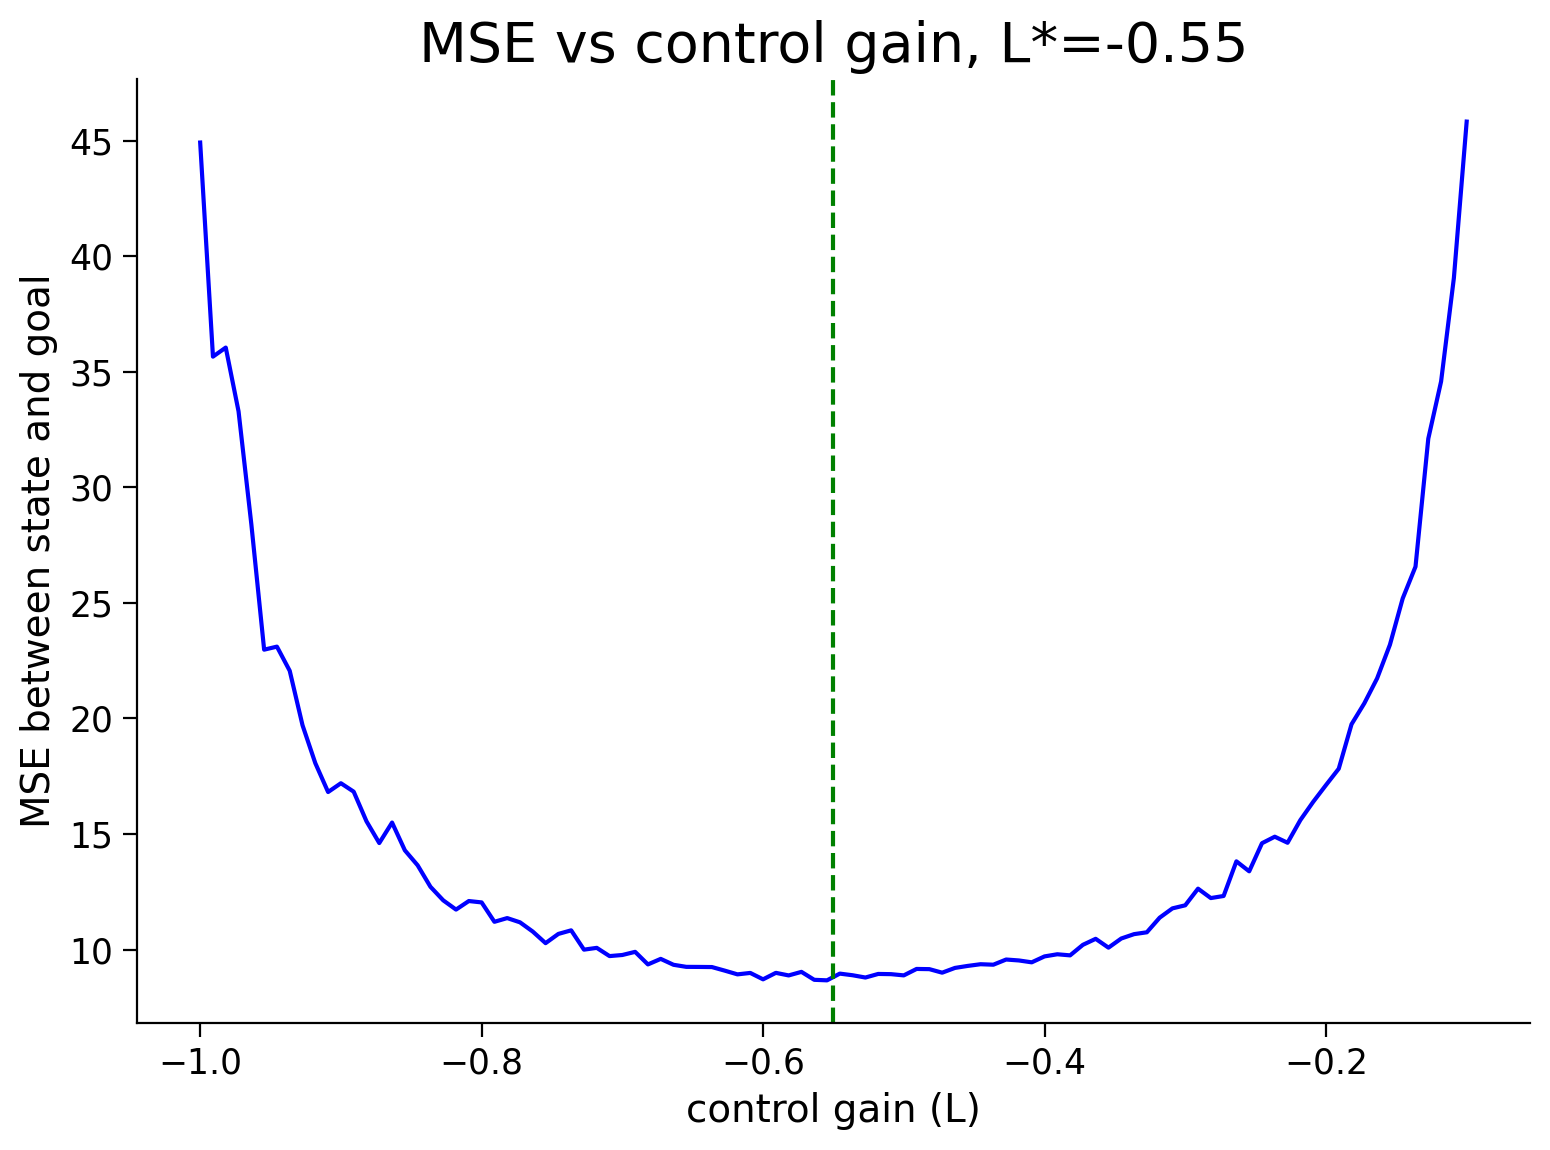

In [7]:
#@markdown Ejecuta esta celda para visualizar el MSE entre el estado y el objetivo, como función de la ganancia de control
def calculate_plot_mse():
  D, B, noise_var, ini_state = 1.1, 2., 0.1, 2.
  num_iterations = 50
  num_candidates = 100

  control_gain_array = np.linspace(0.1, 1., num_candidates)
  mse_array = np.zeros([num_candidates, num_iterations])

  for j in range(num_iterations):
    for i in range(num_candidates):
      lds = LDS(ini_state, noise_var)
      L = - np.ones(T) * control_gain_array[i]
      s, a = lds.dynamics_closedloop(D, B, L)
      mse_array[i, j] = np.sum(s**2)

  opt = -control_gain_array[np.argmin(np.mean(mse_array, axis=1))]
  plt.figure()
  plt.plot(-control_gain_array, np.mean(mse_array, axis=1), 'b')
  plt.axvline(x=-D/B, color='g', linestyle='--')
  plt.xlabel("control gain (L)", fontsize=14)
  plt.ylabel("MSE between state and goal" , fontsize=14)
  plt.title(f"MSE vs control gain, L*={opt:0.2f}", fontsize=20)
  plt.show()
  return opt


opt = calculate_plot_mse()

In [8]:
#@markdown Asegúrate de ejecutar esta celda para habilitar el widget!

#@markdown Explora los diferentes valores de ganancia de control **`L`** (cercanos al óptimo, y más y menos ambiciosos) \\


display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(L=widgets.FloatSlider(opt, description="L",
                                        min=-1.05, max=0.051))

def simulate_L(L):
  D, B, noise_var, ini_state = 1.1, 2., 0.1, 2.
  static_noise  = True
  lds = LDS(ini_state, noise_var, static_noise)
  # Closed loop control with the numerical optimal control gain
  Lt = np.ones(T) * L
  s_closed_loop_choice, _ = lds.dynamics_closedloop(D, B, Lt)
  # Closed loop control with the theoretical optimal control gain
  L_theory = - D / B * np.ones(T)
  s_closed_loop_theoretical, _ = lds.dynamics_closedloop(D, B, L_theory)
  # Plotting closed loop state evolution with both theoretical and numerical optimal control gains
  plt.figure(figsize=(10, 6))
  plot_vs_time(s_closed_loop_theoretical,
               'Closed Loop (Theoretical optimal control gain)', 'b',
               show=False)
  plot_vs_time(s_closed_loop_choice,
               f'Closed Loop (your choice of L = {L:.2f})', 'g',
               goal=np.zeros(T), ylabel="State", show=False)
  plt.title(f'Closed-loop State Evolution. L* = {opt:.2f}')
  plt.show()

interactive(children=(FloatSlider(value=-0.5545454545454546, description='L', max=0.051, min=-1.05), Output())…

---
# Sección 2: Diseñando una entrada de control óptimo utilizando un regulador lineal cuadrático (controlador LQR)



## Sección 2.1 Restricciones sobre el sistema
Ahora empezaremos a imponer restricciones adicionales sobre nuestro sistema. Por ejemplo, si exploraste distintos valores $s_{init}$ arriba, deberías haber visto grandes valores de $a_t$ para llegar al ratón en un corto periodo de tiempo. Sin embargo, a lo mejor debido al diseño de nuestro jetpack, es peligroso utilizar grandes cantidades de combustible en un único paso de tiempo. Definitivamente no queremos explotar, así que nos gustaría mantener las acciones $a_t$ lo más pequeñas posibles mientras mantenemos buen control.

Además, en el Ejercicio 1, nos restringimos a una ganancia de control estática $L_t \equiv L$. ¿Como lo variaríamos si pudiesemos?

Esto nos lleva a una manera más realista y criteriosa de diseñar la entrada de control óptima.
### Armando una función de costo

En un problema LQR con horizonte finito, la función de costo se define como:
\begin{eqnarray}
J({\bf s},{\bf a}) &=& J_{state}({\bf s}) + \rho J_{control}({\bf a}) \\
 &=& \sum_{t = 0}^{T} (s_{t}-g)^2 + \rho \sum_{t=0}^{T-1}a_{t}^2 \tag{3}
\end{eqnarray}

donde $\rho$ es el peso o ponderación en el costo del esfuerzo del control, comparado con el costo de no estar en el objetivo. Aquí, ${\bf a} = \{a_t\}_{t=0}^{T-1}$, ${\bf s} = \{s_t\}_{t=0}^{T}$. Esta es una función de costos cuadrática. En el Ejercicio $2$, solo exploraremos $g=0$, en cuyo caso $J_{state}({\bf s})$ también puede expresarse como $\sum_{t = 0}^{T} s_{t}^2$. En el Ejercicio $3$, exploraremos un objetivo no-nulo (distinto a cero) que varía en el tiempo.

El objetivo del problema LQR es encontrar un control ${\bf a}$ tal que $J({\bf s},{\bf a})$ sea mínimo. El objetivo entonces es encontrar la ganancia de control en cada punto del tiempo, es decir,

$$ \text{argmin} _{\{L_t\}_{t=0}^{T-1}}  J({\bf s},{\bf a}) \tag{4} $$

donde $a_t = L_t s_t$.


## Sección 2.2 Resolviendo LQR
La solución a la Ecuación (4) (LQR para un horizonte de tiempo finito), puede ser obtenida mediante Programación Dinámica. Para más detalles, mira [esta clase por Stephen Boyd](https://stanford.edu/class/ee363/lectures/dlqr.pdf).

Para un horizonte de tiempo infinito, uno puede obtener una solución en forma cerrada utilizando las ecuaciones de Riccati, y la solución para la ganancia de control se vuelve tiempo-invariante (es decir, $L_t \equiv L$). Usaremos esto en el Ejercicio 4. Para más detalles, mira esta [otra clase por Stephen Boyd](https://stanford.edu/class/ee363/lectures/dlqr-ss.pdf).

Bibliografía adicional para toda la sección: \\
[Bertsekas, Dimitri P. "Dynamic programming and optimal control". Vol. 1. No. 2. Belmont, MA: Athena scientific, 1995.](http://www.athenasc.com/dpbook.html)


### Ejercicio de Programación 2.2: Implementa la función de costo
La función de costo $J_{control}({\bf s}, {\bf a})$ puede ser dividida en dos partes: $J_{state}({\bf s})$ y $J_{control}({\bf a})$.

Programa estas dos partes en los métodos de las clases `def calculate_J_state` y `def calculate_J_control` en la siguiente clase ayudante para LQR.


In [9]:
class LQR(LDS):
  def __init__(self, ini_state, noise_var, static_noise=False):
    super().__init__(ini_state, noise_var, static_noise)
    self.T = T
    self.goal = np.zeros(T)  # The class LQR only supports g=0

  def control_gain_LQR(self, D, B, rho):
    P = np.zeros(self.T)  # Dynamic programming variable
    L = np.zeros(self.T - 1)  # control gain
    P[-1] = 1
    for t in range(self.T - 1):
        P_t_1 = P[self.T - t - 1]
        P[self.T - t-2] = (1 + P_t_1 * D**2 - D * P_t_1 * B / (rho + P_t_1 * B**2) * B * P_t_1 * D)
        L[self.T - t-2] = - (1 / (rho + P_t_1 * B**2) * B * P_t_1 * D)
    return L

  def calculate_J_state(self, s:np.ndarray):
    # calculate the state
    J_state = np.sum((s - self.goal)**2)

    return J_state

  def calculate_J_control(self, a:np.ndarray):
    # calculate the control
    J_control = np.sum(a**2)

    return J_control

# Test class
# test_lqr_class(LQR)

### Demo Interactivo 2.2: LQR al origen

En este ejercicio, usaremos tu nuevo controlador LQR para seguir un objetivo estático en $g=0$. Aquí exploraremos como $\rho$ afecta sus acciones haciendo:

1.   Usando la Ecuación 3, encuentra un valor para $\rho$ que te consiga el mismo costo y ganancia de control que el Ejercicio 1.
2.   Elige un valor más grande para $\rho$ y observa el efecto en la acción.
3.   Prueba aumentar $\rho$ a 2. ¿Como cambió la ganancia de control? \\
4.   Para diferentes valores de $\rho$, ¿como varía la ganancia de control?

In [10]:
#@markdown ¡Asegúrate de ejecutar esta celda para habilitar el widget!

# @markdown Explore different values of control gain `L` (close to optimal, over- and under- ambitious) \\

display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(rho=widgets.FloatSlider(25.,
                                          description="ρ",
                                          min=0., max=50.))

def simulate_rho(rho=1.):
  D, B, ini_state, noise_var = 1.1, 2., 1., .1  # state parameter
  static_noise = True
  lqr = LQR(ini_state, noise_var, static_noise)
  L = lqr.control_gain_LQR(D, B, rho)
  s_lqr, a_lqr = lqr.dynamics_closedloop(D, B, L)

  plt.figure(figsize=(14, 4))
  plt.suptitle('LQR Control for rho = {}'.format(rho), y=1.05)

  plt.subplot(1, 3, 1)
  plot_vs_time(s_lqr,'State evolution','b',goal=np.zeros(T), show=False)
  plt.ylabel('State $s_t$')

  plt.subplot(1, 3, 2)
  plot_vs_time(a_lqr,'LQR Action','b', show=False)
  plt.ylabel('Action $a_t$')

  plt.subplot(1, 3, 3)
  plot_vs_time(L,'Control Gain','b', show=False)
  plt.ylabel('Control Gain $L_t$')

  plt.tight_layout()
  plt.show()

interactive(children=(FloatSlider(value=25.0, description='ρ', max=50.0), Output()), _dom_classes=('widget-int…

In [11]:
# explicación a eliminar
"""
* rho=0 te dará el mismo costo y ganancia de control del Ejercicio 1,
anulando el término de costo.
* Un valor de rho pequeño tendrá una solución similar a (a), pero con
  valores potencialmente altos para |a[t]|.
* Un valor de rho grande como 2 llevará a valores pequeños de |a[t]|.
* La ganancia de control se vuelve más variante en el tiempo (en vez de ser bastante estática)
  para valores grandes de rho. Para algunos valores de parámetros, L[t] oscila a lo largo de
  toda la trayectoria con tal de mantener $|a_t|$ bajo. Prueba D = 0.9, B = 2 y rho = 2.
""";

## Sección 2.3: El compromiso entre el costo de estado y el costo de control

En el Ejercicio 2.1, implementaste código para calcular $J_{state}$ y $J_{control}$ en los métodos de la clase LQR.

Ahora las graficaremos juntas para distintos valores de $\rho$, para explorar el compromiso entre el costo de estado y el costo de control


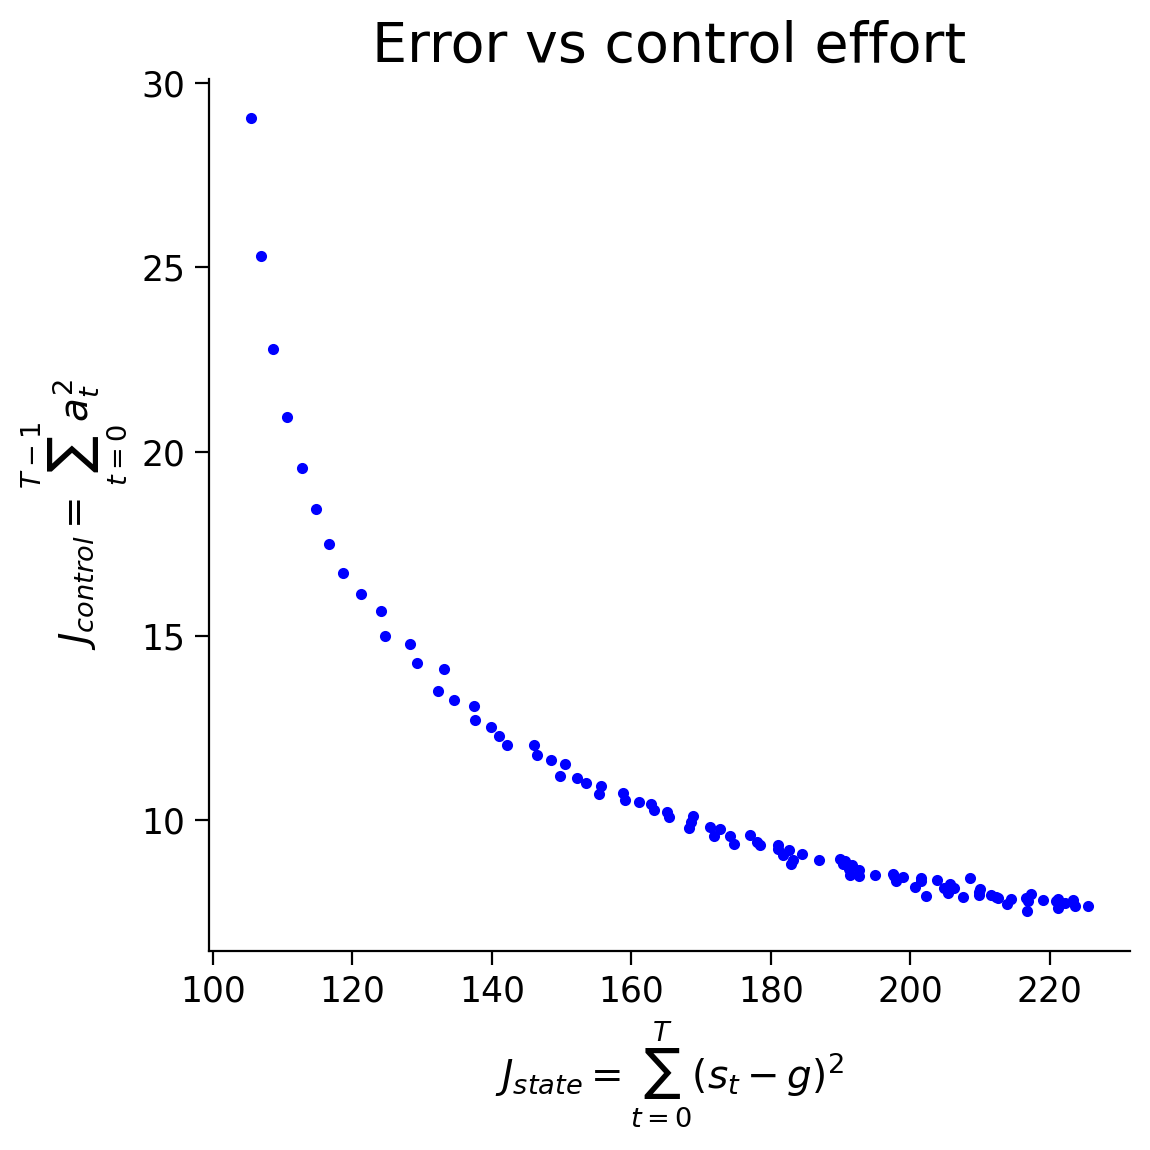

In [12]:
#@markdown Ejecuta esta celda para visualizar el compromiso entre el costo del estado y el costo de control
def calculate_plot_costs():

  D, B, noise_var, ini_state = 1.1, 2., 0.1, 10.
  num_iterations = 50
  num_candidates = 100

  rho_array = np.linspace(0.2, 40, num_candidates)
  J_state = np.zeros([num_candidates, num_iterations])
  J_control = np.zeros([num_candidates, num_iterations])

  for j in range(num_iterations):
    for i in np.arange(len(rho_array)):
      lqr = LQR(ini_state, noise_var)
      L = lqr.control_gain_LQR(D, B, rho_array[i])
      s_lqr, a_lqr = lqr.dynamics_closedloop(D, B, L)
      J_state[i, j] = lqr.calculate_J_state(s_lqr)
      J_control[i, j] = lqr.calculate_J_control(a_lqr)
  J_state = np.mean(J_state, axis=1)
  J_control = np.mean(J_control, axis=1)

  fig = plt.figure(figsize=(6, 6))
  plt.plot(J_state, J_control, '.b')
  plt.xlabel("$J_{state} = \sum_{t = 0}^{T} (s_{t}-g)^2$", fontsize=14)
  plt.ylabel("$J_{control} = \sum_{t=0}^{T-1}a_{t}^2$" , fontsize=14)
  plt.title("Error vs control effort", fontsize=20)
  plt.show()


calculate_plot_costs()

Deberías poder ver la curva con forma de 'C' en la parte de abajo, formando el compromiso entre el costo de estado y el costo de control con control lineal óptimo. Para un valor deseado de costo de estado, no podemos obtener un costo de control más bajo que el de la curva del gráfico de arriba. Similarmente, para un valor deseado de costo de control, debemos aceptar esa cantidad de costo de estado. Por ejemplo, si sabés que tienes una cantidad limitada de combustible, esta determinará el máximo costo de control $J_{control}^{max}$.


Es posible mostrar que no podrás seguir tu estado con mayor precisión  que la que corresponde a $J_{state}$ dada por el gráfico de arriba. Esta es entonces una curva importante para tomar en cuenta cuando se diseña un sistema y se explora como controlarlo.

---
# Sección 3: LQR para seguir un objetivo variante en el tiempo

En una situación más realista, el ratón estaría moviendose constantemente. Supongamos que puedes predecir el movimiento del ratón a medida que salta de un lado a otro. Esta será la trayectoria objetivo $g_t$.

Cuando el estado objetivo $g_t$,no es $0$, la función de costo se convierte en
$$ J({\bf a}) = \sum_{t = 0}^{T} (s_{t}- g_t) ^2 + \rho \sum_{t=0}^{T-1}(a_{t}-\bar a_t)^2$$
Aquí, $\bar a_t$ Es la acción deseada dada la trayectoria objetivo. En otras palabras, el controlador ahora considera el objetivo para el próximo paso de tiempo, y diseña una acción preliminar que lleva al estado al objetivo deseado en el próximo paso de tiempo. Específicamente, sin tomar en cuenta ruido $w_t$, nos gustaría diseñar $\bar a_t$ tal que $s_{t+1}=g_{t+1}$. De la Ecuación $(1)$, entonces:

\begin{eqnarray*}
g_{t+1} &=& Ds_t + B \bar a_t\\
\bar a_{t} &=& \frac{- Ds_t + g_{t+1}}{B}\\
\end{eqnarray*}

La acción final $a_t$ es producida agregandole esta acción deseada $\bar a_t$ al término con la ganancia de control $L_t(s_t - g_t)$.

In [13]:
#@markdown Ejecuta esta celda para incluir la clase
#@markdown para control LQR al objetivo tiempo-variante deseado
class LQR_tracking(LQR):
  def __init__(self, ini_state, noise_var, goal):
    super().__init__(ini_state, noise_var)
    self.T = T
    self.goal = goal

  def dynamics_tracking(self, D, B, L):

    s = np.zeros(self.T) # states intialization
    s[0] = self.ini_state

    noise = np.sqrt(self.noise_var) * standard_normal_noise

    a = np.zeros(self.T) # control intialization
    a_bar = np.zeros(self.T)
    for t in range(self.T - 1):
      a_bar[t] = ( - D * s[t] + self.goal[t + 1]) / B
      a[t] =  L[t] * (s[t] - self.goal[t]) + a_bar[t]
      s[t + 1] = D * s[t] + B * a[t] + noise[t]

    return s, a, a_bar

  def calculate_J_state(self,s):
    J_state = np.sum((s-self.g)**2)
    return J_state

  def calculate_J_control(self, a, a_bar):
    J_control = np.sum((a-a_bar)**2)
    return J_control

### Demo Interactiva 3: Control LQR al objetivo tiempo-variante deseado

Usa la demo debajo para explorar como LQR sigue un objetivo que varía en el tiempo. Partiendo del objetivo senoidal de función `sin`, investiga como el sistema reacciona con distintos valores de $\rho$ y distintas varianzas del ruido del proceso. Luego, explora otros objetivos variantes en el tiempo, como la función escalón y la rampa.

In [26]:
# @markdown Make sure you execute this cell to enable the widget!

# @markdown Explore different values of control gain `L` (close to optimal, over- and under- ambitious) \\

display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(rho=widgets.FloatSlider(20., description="ρ", min=0.1, max=4000.),
                  noise_var=widgets.FloatSlider(0.1, description="noise_var", min=0., max=1.),
                  goal_func=widgets.RadioButtons(options=['sin', 'step', 'ramp'],
                                                 description='goal_func:',
                                                 disabled=False))

def simulate_tracking(rho, noise_var, goal_func):
  D, B, ini_state = 1.1, 1., 0.
  if goal_func == 'sin':
    goal = np.sin(np.arange(T) * 2 * np.pi * 5 / T)
  elif goal_func == 'step':
    goal = np.zeros(T)
    goal[int(T / 3):] = 1.
  elif goal_func == 'ramp':
    goal = np.zeros(T)
    goal[int(T / 3):] = np.arange(T - int(T / 3)) / (T - int(T / 3))

  lqr_time = LQR_tracking(ini_state, noise_var, goal)
  L = lqr_time.control_gain_LQR(D, B, rho)
  s_lqr_time, a_lqr_time, a_bar_lqr_time = lqr_time.dynamics_tracking(D, B, L)

  plt.figure(figsize=(13, 5))
  plt.suptitle('LQR Control for time-varying goal', y=1.05)
  plt.subplot(1, 2, 1)
  plot_vs_time(s_lqr_time, 'State evolution $s_t$', 'b',
               goal, ylabel="State", show=False)
  plt.subplot(1, 2, 2)
  plot_vs_time(a_lqr_time, 'Action $a_t$', 'b',
               ylabel="Action", show=False)
  plt.show()

interactive(children=(FloatSlider(value=20.0, description='ρ', max=4000.0, min=0.1), FloatSlider(value=0.1, de…

---
# Sección 4: Control de un estado parcialmente observable usando un controlador Lineal Cuadrático Gaussiano (LQG)


## Sección 4.1 Introduciendo al Controlador LQG

En la práctica, el controlador no tiene acceso completo al estado. Por ejemplo, ¡tu jetpack en el espacio puede estar siendo controlado por Centro de Control de Misión en la Tierra! En este caso, se obtendrán mediciones ruidosas ($m_t$) del estado por medio de radar, y el controlador necesita: (1) estimar el estado verdadero, y (2) diseñar una acción basada en esta estimación

Afortunadamente, el principio de separación nos dice que lo óptimo que podemos hacer nosotros para atacar este problema es hacer (1) y (2) por separado. Esto hace que nuestro problema sea mucho más simple, ya que ya sabemos como hacer cada uno de los pasos.

1) *Estimación del Estado*  
¿Podemos recuperar el estado a partir de la medición?
De la clase anterior, sabemos que los estados $\hat{s}_t$ pueden ser estimados de las mediciones $m_t$ utilizando el __filtro de Kalman__.

2) *Diseñar la acción*  
En las Secciones 2 y 3 de esta clase, aprendimos sobre el controlador LQR que diseña una acción en base al estado. El principio de separación nos dice que es suficiente reemplazar el uso del estado en LQR por el estado *estimado*, es decir,

$$a_t = L_t \hat s_t$$

Las dinámicas de estado entonces serán:
$$s_{t+1} = D s_t + B a_t + w_t$$
donde $w_t$ es el ruido del proceso (proc_noise), y la observación / medición is:
$$ m_t = C s_t + v_t$$
con $v_t$ siendo el ruido de la medición (meas_noise).

La combinación de (1) la estimación del estado y (2) el diseño de la acción usando LQR es conocida como **Control Lineal Cuadrático Gaussiano (LQG, por sus siglas en inglés, Linear Quadratic Gaussian)**. Ayer, completaste el código para el filtro de Kalman. Basado en eso, programarás el controlador LQG. Para estos ejercicios, volveremos a utilizar el objetivo $g=0$, como en la Sección 2.


### Demo Interactiva 4.1: El filtro de Kalman en conjunto con un controlador lineal a lazo cerrado (control LQG)

En la clase `MyKalmanFilter`, el método `filter_control` implementa filtrado en realimentación a lazo cerrado. Es una combinación de generar muestras (estados $s_t$) y filtrandolas (generano estimaciones de estado $\hat s_t$), como habrás visto en el tutorial anterior. La única diferencia entre lo visto en ese tutorial y ahora es que ahora el filtro de Kalman está en lazo cerrado con el controlador. Por ende, cada estado $s_{t+1}$ recibe una entrada $a_t$, que asimismo depende de la estimación del estado en el paso de tiempo anterior $\hat s_t$.

Debajo encontraran código de la clase (`MyKalmanFilter`) que implementa un filtro de Kalman a lazo cerrado. Este código te proveerá intuición acerca de la actualización de las acciones (`control_policy_LQG`) y la estimación de los estados (`state_dynamics_LQG`). Por favor sientete libre de inspeccionar las funciones de ayuda y las clases para ver los detalles.


You should have seen the next cell containing `KalmanFilter` class yesterday, with the exception of the controller acting on the state estimate in feedback, using the methods/equations you will find below.

Ya deberías haber visto la siguiente celda que contiene la clase `MyKalmanFilter` en el tutorial anterior, pero sin el controlador actuando en la estimación del estado realimentado, usando los métodos/ecuaciones que encontrarás abajo.

In [15]:
#@markdown Ejecuta esta celda para incluir la clase KalmanFilter
class KalmanFilter():
  def __init__(self, transition_matrix, transition_covariance,
               observation_matrix, observation_covariance,
               initial_state_mean, initial_state_covariance):
    self.D = transition_matrix
    self.Q = transition_covariance
    self.C = observation_matrix
    self.R = observation_covariance
    self.prior = gaussian(initial_state_mean, initial_state_covariance)

  def get_estimate(self, m, a):

    predicted_estimate = self.D * self.prior.mean + a
    predicted_covariance = self.D**2 * self.prior.cov + self.Q

    innovation_estimate = m - self.C * predicted_estimate
    innovation_covariance = self.C**2 * predicted_covariance + self.R

    # Kalman gain is the weight given to the innovation (ie., the difference between the measurement and the predicted measurement)
    K = predicted_covariance * self.C / innovation_covariance
    updated_mean = predicted_estimate + K * innovation_estimate
    updated_cov = (1 - K * self.C) * predicted_covariance
    posterior = gaussian(updated_mean, updated_cov)

    # Current posterior becomes next-step prior
    self.prior = posterior

    return posterior.mean


class LQG():
  def __init__(self, transition_matrix, transition_covariance,
               observation_matrix, observation_covariance, initial_state_mean,
               initial_state_covariance, ntrials=1, static_noise=False):
    self.D = transition_matrix
    self.Q = transition_covariance
    self.C = observation_matrix
    self.R = observation_covariance
    self.static_noise = static_noise
    self.ntrials = ntrials
    self.t = 0
    self.latent_states = np.zeros([T, ntrials])
    self.latent_states[0] = initial_state_mean + np.sqrt(initial_state_covariance) * standard_normal_noise[0]

  def step(self, action):
    self.t += 1
    if self.static_noise:
      self.latent_states[self.t] = self.D * self.latent_states[self.t-1] + action + np.sqrt(self.Q) * standard_normal_noise[self.t-1]
      measurement = self.C * self.latent_states[self.t] + np.sqrt(self.R) * standard_normal_noise_meas[self.t]
    else:
      self.latent_states[self.t] = self.D * self.latent_states[self.t-1] + action + np.sqrt(self.Q) * np.random.randn(self.ntrials)
      measurement = self.C * self.latent_states[self.t] + np.sqrt(self.R) * np.random.randn(self.ntrials)
    return measurement

  def get_control_gain_infinite(self, rho):
    P = np.zeros(T)
    L = np.zeros(T - 1)
    P[-1] = 1

    for t in range(T - 1):
        P_t_1 = P[T - t - 1]
        P[T - t-2] = (1 + P_t_1 * self.D**2 - self.D * P_t_1 / (rho + P_t_1) * P_t_1 * self.D)
        L[T - t-2] = - (1 / (rho + P_t_1)* P_t_1 * self.D)

    return L[0]


def control_policy_LQG(control_gain, estimated_state):
  current_action =  control_gain * estimated_state
  return current_action

In [16]:
# # inspecciona los métodos 'control_policy_LQG' y 'state_dynamics_LQG':

# def control_policy_LQG(self, mean_estimated_state, control_gain):
#   current_action =  control_gain * mean_estimated_state
#   return current_action

# def state_dynamics_LQG(self, current_latent_state, current_action):

#   current_latent_state = np.dot(self.transition_matrices, current_latent_state)\
#                         + np.dot(self.control_matrices, current_action)\
#                         + np.random.multivariate_normal(np.zeros(self.n_dim_state),
#                                                         self.transition_covariance)
#   return current_latent_state

Mira el código de ayuda para la clase `MyKalmanFilter` arriba. En los siguientes ejercicios, usaremos la misma notación que hemos estado usando en este tutorial; se há provisto código para convertirlo a la representación que `MyKalmanFilter` espera.

Usa la demo interactiva debajo para refrescar tu memoria de como un filtro de Kalman estima un estado. `C` escala la matriz de observación.

In [17]:
#@markdown ¡Asegúrate de ejecutar esta celda para habilitar el widget!

display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(C = widgets.FloatSlider(1., description="C", min=0., max=3.),
                  proc_noise = widgets.FloatSlider(.1, description="proc_noise", min=0.0, max=1.),
                  meas_noise = widgets.FloatSlider(.2, description="meas_noise", min=0.1, max=1.))

def simulate_kf_no_control(C, proc_noise, meas_noise):

  D = 0.9
  ini_state_mean = 5.
  ini_state_cov = .1
  estimates = np.zeros(T)
  estimates[0] = ini_state_mean

  filter = KalmanFilter(transition_matrix=D,
                        transition_covariance=proc_noise,
                        observation_matrix=C,
                        observation_covariance=meas_noise,
                        initial_state_mean=ini_state_mean,
                        initial_state_covariance=ini_state_cov)

  system = LQG(transition_matrix=D,
               transition_covariance=proc_noise,
               observation_matrix=C,
               observation_covariance=meas_noise,
               initial_state_mean=ini_state_mean,
               initial_state_covariance=ini_state_cov,
               static_noise=False)

  action = 0
  for t in range(1, T):
    measurement = system.step(action)
    estimates[t] = filter.get_estimate(measurement, action)

  plot_kf_state_vs_time(system.latent_states, estimates,
                        'State estimation with KF (Stable system without control input)')

interactive(children=(FloatSlider(value=1.0, description='C', max=3.0), FloatSlider(value=0.1, description='pr…

### Demo Interactiva 4.2: Salida del Controlador LQG con ganancias de control variables

Ahora implementemos el filtro de Kalman con realimentación a lazo cerrado con el controlador. Primero usaremos una ganancia de control arbitraria y un valor fijo para el ruido de la medición. Luego usaremos la ganancia de control del LQR para el desempeño/rendimiento óptimo, variando los valores de $\rho$.

(a) Visualiza la dinámica del sistema $s_t$  con control a lazo cerrado con una ganancia de control arbitraria. Varía esta ganancia de control y observa los cambios.

(b) Varía $\rho$ tpara visualizar la salida del controlador LQG óptimo. Aquí usaremos la ganancia óptima de control *constante*, que es óptima en el caso de un horizonte de tiempo infinito (llega al objetivo y quedate ahí para siempre).

In [18]:
#@markdown ¡Asegúrate de ejecutar esta celda para habilitar el widget!

display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(C = widgets.FloatSlider(1., description="C", min=0., max=3.),
                  L = widgets.FloatSlider(-.3, description="L", min=-.5, max=0.),
                  proc_noise = widgets.FloatSlider(.1, description="proc_noise", min=0.0, max=1.),
                  meas_noise = widgets.FloatSlider(.2, description="meas_noise", min=0.1, max=1.))


def simulate_kf_with_control(C, L, proc_noise, meas_noise):

  D = 1.1
  ini_state_mean = 5.
  ini_state_cov = .1
  estimates = np.zeros(T)
  estimates[0] = ini_state_mean
  control_gain = L

  filter = KalmanFilter(transition_matrix=D,
                        transition_covariance=proc_noise,
                        observation_matrix=C,
                        observation_covariance=meas_noise,
                        initial_state_mean=ini_state_mean,
                        initial_state_covariance=ini_state_cov)

  system = LQG(transition_matrix=D,
               transition_covariance=proc_noise,
               observation_matrix=C,
               observation_covariance=meas_noise,
               initial_state_mean=ini_state_mean,
               initial_state_covariance=ini_state_cov,
               static_noise=True)

  action = 0
  for t in range(1, T):
    measurement = system.step(action)
    estimates[t] = filter.get_estimate(measurement, action)
    action = control_policy_LQG(control_gain, estimates[t])

  title = f'State estimation with KF (control gain = {control_gain})'
  plot_kf_state_vs_time(system.latent_states, estimates, title,
                        goal=np.zeros(T))

interactive(children=(FloatSlider(value=1.0, description='C', max=3.0), FloatSlider(value=-0.3, description='L…

### Demo Interactiva 4.3: LQG variando los costos de controlar

Ahora vemos el desempeño del controlador LQG. Usaremos una ganancia del controlador LQG donde la ganancia del controlador es de un sistema con un horizonte infinito. En este caso, la ganancia de control óptimo resulta ser constante.

Varía el valor de $\rho$ de $0$ a valores grandes para observar el efecto en el estado.

In [19]:
# @markdown Make sure you execute this cell to enable the widget!

display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(rho=widgets.FloatSlider(25., description="ρ", min=0., max=50.))

def simulate_kf_with_lqg(rho):

  D=1.1
  C=1.
  ini_state_mean = 1.
  ini_state_cov = 2.
  proc_noise=0.1
  meas_noise=0.2
  estimates = np.zeros(T)
  estimates[0] = ini_state_mean


  filter = KalmanFilter(transition_matrix=D,
                      transition_covariance=proc_noise,
                      observation_matrix=C,
                      observation_covariance=meas_noise,
                      initial_state_mean=ini_state_mean,
                      initial_state_covariance=ini_state_cov)

  system = LQG(transition_matrix=D,
              transition_covariance=proc_noise,
              observation_matrix=C,
              observation_covariance=meas_noise,
              initial_state_mean=ini_state_mean,
              initial_state_covariance=ini_state_cov,
              static_noise=True)

  control_gain = system.get_control_gain_infinite(rho)

  action = 0
  for t in range(1, T):
    measurement = system.step(action)
    estimates[t] = filter.get_estimate(measurement, action)
    action = control_policy_LQG(control_gain, estimates[t])

  title = 'State estimation with KF (LQG controller)'
  plot_kf_state_vs_time(system.latent_states, estimates, title,
                        goal=np.zeros(T))

interactive(children=(FloatSlider(value=25.0, description='ρ', max=50.0), Output()), _dom_classes=('widget-int…

### Demo Interactiva 4.4: ¿Como influencian el ruido del proceso y el ruido de la medición al estado controlado y la acción deseada?

El ruido del proceso $w_t$ (proc_noise) y el ruido de la medición $v_t$ (meas_noise) tienen efectos muy diferentes en el estado controlado.

(a) Para visualizar esto, juega con los deslizadores para obtener una intuición de como el ruido del proceso y el ruido de la medición afectan el estado controlado. ¿Como difieren estas dos fuentes de ruido?

(b) Luego, para distintos niveles de ruido de proceso y ruido de medición (pero con la misma política de control entre todos estos valores), grafica el error cuadrático medio (MSE) entre el estado y el objetivo, y el costo de control. ¿Que puedes observar?


In [20]:
#@markdown ¡Asegúrate de ejecutar esta celda para habilitar el widget!

display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(proc_noise=widgets.FloatSlider(.1, description="proc_noise",
                                                 min=0.1, max=1.),
                  meas_noise=widgets.FloatSlider(.2, description="meas_noise",
                                                 min=0.1, max=1.)
                  )

def lqg_slider(proc_noise, meas_noise):

  D = 1.1
  C = 1.
  rho = 1.
  ini_state_mean = 1.
  ini_state_cov = 2.
  estimates = np.zeros(T)
  estimates[0] = ini_state_mean

  filter = KalmanFilter(transition_matrix=D,
                      transition_covariance=proc_noise,
                      observation_matrix=C,
                      observation_covariance=meas_noise,
                      initial_state_mean=ini_state_mean,
                      initial_state_covariance=ini_state_cov)

  system = LQG(transition_matrix=D,
              transition_covariance=proc_noise,
              observation_matrix=C,
              observation_covariance=meas_noise,
              initial_state_mean=ini_state_mean,
              initial_state_covariance=ini_state_cov,
              static_noise=True)

  control_gain = system.get_control_gain_infinite(rho)

  action = 0
  for t in range(1, T):
    measurement = system.step(action)
    estimates[t] = filter.get_estimate(measurement, action)
    action = control_policy_LQG(control_gain, estimates[t])

  title = 'State estimation with KF (LQG controller)'
  plot_kf_state_vs_time(system.latent_states, estimates, title,
                        goal=np.zeros(T))

interactive(children=(FloatSlider(value=0.1, description='proc_noise', max=1.0, min=0.1), FloatSlider(value=0.…

## Sección 4.2 Efectos del ruido en el LQG

Ahora cuantificaremos como el costo del estado y los costos de controlar cambian cuando cambiamos los niveles de ruido del proceso y de las mediciones. Para hacer eso, correremos muchas simulaciones, iterando sobre distintos niveles de ruido de proceso y mediciones, y registrando el MSE y costo de control para cada uno. Corre la celda debajo para realizar estas simulaciones y graficarlas. ¿Que interpretas de estos resultados?

In [21]:
#@markdown Ejecuta esta celda para cuantificar la dependencia del costo del estado
#@markdown y de control en el ruido del proceso y de la medición (tarda ~20 segundos)

display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(D=widgets.FloatSlider(description="D",
                                        min=0.01, max=4., value=1.1,
                                        step=0.01)
                  )

def transit_matrix_slider(D):
  C = 1  # observation matrix
  ini_state = 5  # initial state mean
  ini_state_cov = 1  # initial state covariance
  rho = 1  # control effort parameter
  n_iter = 50
  n_ops = 20
  process_noise_var = .1
  measurement_noise_var = .2

  # Implement LQG control over n_iter iterations, and record the MSE between state and goal
  MSE_array_N_meas = []
  MSE_array_N_proc = []
  Jcontrol_array_N_meas = []
  Jcontrol_array_N_proc = []

  meas_noise_array = np.linspace(0.1, 3, n_ops)
  proc_noise_array = np.linspace(0.1, 3, n_ops)

  # Try several proc noises, but same measurement var
  MSE_array_proc = []
  Jcontrol_array_proc = []

  for proc_noise in proc_noise_array:
    transition_covariance = proc_noise
    observation_covariance = measurement_noise_var

    # Controller
    lqg = LQG(D, transition_covariance, C, observation_covariance, ini_state, ini_state_cov, n_iter)
    control_gain_lqg = lqg.get_control_gain_infinite(rho)

    # Filtering
    filter = KalmanFilter(D, transition_covariance, C, observation_covariance, ini_state, ini_state_cov)

    filtered_state_means_impl = np.zeros([T, n_iter])
    filtered_state_covariances_impl = np.zeros([T, n_iter])
    measurement = np.zeros([T, n_iter])
    action_cost = np.zeros([T, n_iter])

    action = np.zeros(n_iter)
    for t in range(1, T):
      measurement[t] = lqg.step(action)

      filter.get_estimate(measurement[t], action)

      filtered_state_means_impl[t] = filter.prior.mean
      filtered_state_covariances_impl = filter.prior.cov

      action = control_gain_lqg * filter.prior.mean
      action_cost[t] = rho * action**2

    state_cost = lqg.latent_states**2

    MSE_array_proc.append(np.cumsum(state_cost))
    Jcontrol_array_proc.append(np.cumsum(action_cost))

  MSE_array_proc = np.array(MSE_array_proc)
  Jcontrol_array_proc = np.array(Jcontrol_array_proc)

  # Try several measurement noises, but same proc var
  MSE_array_meas = []
  Jcontrol_array_meas = []

  for meas_noise in meas_noise_array:
    transition_covariance = process_noise_var
    observation_covariance = meas_noise

    # Controller
    lqg = LQG(D, transition_covariance, C, observation_covariance, ini_state, ini_state_cov, n_iter)
    control_gain_lqg = lqg.get_control_gain_infinite(rho)

    # Filtering
    filter = KalmanFilter(D, transition_covariance, C, observation_covariance, ini_state, ini_state_cov)

    filtered_state_means_impl = np.zeros([T, n_iter])
    filtered_state_covariances_impl = np.zeros([T, n_iter])
    measurement = np.zeros([T, n_iter])
    action_cost = np.zeros([T, n_iter])

    action = np.zeros(n_iter)
    for t in range(1, T):
      measurement[t] = lqg.step(action)

      filter.get_estimate(measurement[t], action)
      filtered_state_means_impl[t] = filter.prior.mean
      filtered_state_covariances_impl = filter.prior.cov

      action = control_gain_lqg * filter.prior.mean
      action_cost[t] = rho * action**2

    state_cost = lqg.latent_states**2

    MSE_array_meas.append(np.cumsum(state_cost))
    Jcontrol_array_meas.append(np.cumsum(action_cost))

  MSE_array_meas = np.array(MSE_array_meas)
  Jcontrol_array_meas = np.array(Jcontrol_array_meas)

  # Compute statistics
  MSE_array_proc_mean = np.mean(np.array(MSE_array_proc), axis = 1)
  MSE_array_proc_std = np.std(np.array(MSE_array_proc), axis = 1)
  MSE_array_meas_mean = np.mean(np.array(MSE_array_meas), axis = 1)
  MSE_array_meas_std = np.std(np.array(MSE_array_meas), axis = 1)

  Jcontrol_array_proc_mean = np.mean(np.array(Jcontrol_array_proc), axis = 1)
  Jcontrol_array_proc_std = np.std(np.array(Jcontrol_array_proc), axis = 1)
  Jcontrol_array_meas_mean = np.mean(np.array(Jcontrol_array_meas), axis = 1)
  Jcontrol_array_meas_std = np.std(np.array(Jcontrol_array_meas), axis = 1)

  # Visualize the quantification
  f, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 8))

  axs[0, 0].plot(proc_noise_array, MSE_array_proc_mean, 'r-')
  axs[0, 0].fill_between(proc_noise_array,
                        MSE_array_proc_mean+MSE_array_proc_std,
                        MSE_array_proc_mean-MSE_array_proc_std,
                        facecolor='tab:gray', alpha=0.5)
  axs[0, 0].set_title('Effect of process noise')
  axs[0, 0].set_ylabel('State Cost\n(MSE between state and goal)')

  axs[0, 1].plot(meas_noise_array, MSE_array_meas_mean, 'r-')
  axs[0, 1].fill_between(meas_noise_array,
                        MSE_array_meas_mean + MSE_array_meas_std,
                        MSE_array_meas_mean - MSE_array_meas_std,
                        facecolor='tab:gray', alpha=0.5)
  axs[0, 1].set_title('Effect of measurement noise')

  axs[1, 0].plot(proc_noise_array, Jcontrol_array_proc_mean, 'r-')
  axs[1, 0].fill_between(proc_noise_array,
                        Jcontrol_array_proc_mean + Jcontrol_array_proc_std,
                        Jcontrol_array_proc_mean - Jcontrol_array_proc_std,
                        facecolor='tab:gray', alpha=0.5)
  axs[1, 0].set_xlabel('Process Noise')
  axs[1, 0].set_ylabel('Cost of Control')

  axs[1, 1].plot(meas_noise_array, Jcontrol_array_meas_mean, 'r-')
  axs[1, 1].fill_between(meas_noise_array,
                        Jcontrol_array_meas_mean + Jcontrol_array_meas_std,
                        Jcontrol_array_meas_mean - Jcontrol_array_meas_std,
                        facecolor='tab:gray', alpha=0.5)
  axs[1, 1].set_xlabel('Measurement Noise')

  plt.show()

interactive(children=(FloatSlider(value=1.1, description='D', max=4.0, min=0.01, step=0.01), Output()), _dom_c…

---
# Resumen

En este tutorial, extendiste la idea de políticas óptimas al ejemplo del Astrogato. Has aprendido como diseñar un controlador óptimo con observabilidad completa del estado (regulador lineal cuadrático - LQR), y con observabilidad parcial del estado (lineal cuadrático gaussiano - LQG).